RAG MVP for Operator Training (text + images)

In [42]:
import os, io
from PIL import Image
import fitz  # PyMuPDF
import numpy as np
import faiss
from IPython.display import display

from sentence_transformers import SentenceTransformer
from langchain_openai import ChatOpenAI
from langchain.schema import Document


In [43]:
# --- 1) Settings ---
PDF_PATH = "data/ManualOp-Modo Manual SIF400_merged_SIF402.pdf"          # Place PDF here
MACHINE_NAME = "SIF402"               # Set the machine name
TOP_K = 3                             # Number of retrieved results

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in env")

# --- 2) Models ---
text_model = SentenceTransformer("all-MiniLM-L6-v2")
clip_model = SentenceTransformer("clip-ViT-B-32")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/.no_exist/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/adapter_config.json'
Ignored error while writing commit hash to /home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main'.


In [44]:
# --- 3) Load PDF ---
import hashlib

def load_pdf(PDF_PATH, MACHINE_NAME, text_model, clip_model, min_size=30, ignore_top_pct=0.9, ignore_bottom_pct=0.1):
    """
    Extracts text and images from a PDF with filters.
    
    Args:
        PDF_PATH (str): Path to PDF.
        MACHINE_NAME (str): Machine name prefix (e.g., 'SIF401').
        text_model: SentenceTransformer model for text.
        clip_model: SentenceTransformer model for images.
        min_size (int): Minimum width/height for valid images.

    Returns:
        text_docs, text_embeddings, image_docs, image_embeddings
    """
    doc = fitz.open(PDF_PATH)
    text_docs, text_embeddings = [], []
    image_docs, image_embeddings = [], []
    seen_hashes = set()

    for page_num in range(len(doc)):
        page = doc[page_num]

        # --- Text ---
        text = page.get_text()
        if text.strip():
            emb = text_model.encode(text).astype("float32")
            text_embeddings.append(emb)
            text_docs.append(
                Document(
                    page_content=text,
                    metadata={"page": page_num+1, "machine": MACHINE_NAME}
                )
            )

        # --- Images ---
        img_list = page.get_images(full=True)
        for img_index, img in enumerate(img_list, start=1):
            
            # Example region filter: skip if image is in top 10% or bottom 10% of page        
            x0, y0, x1, y1 = img[0:4]
            page_height = page.rect.height
            if y0 < page_height * ignore_bottom_pct or y1 > page_height * ignore_top_pct:
                continue  # skip logos/icons in header/footer            
            
            xref = img[0]                      
           
            base_img = doc.extract_image(xref)
            img_bytes = base_img["image"]
            img_ext = base_img["ext"]
            img_obj = Image.open(io.BytesIO(img_bytes)).convert("RGB")

            # Filters
            if img_obj.width < min_size or img_obj.height < min_size:
                continue  # skip small logos/icons

            #Skip completely black images
            # img_obj is your PIL.Image object
            img_array = np.array(img_obj)
            # Check if all pixels are 0 (black)
            if img_array.ndim == 3:  # RGB
                if np.all(img_array == 0):
                    continue  # skip completely black image
            elif img_array.ndim == 2:  # grayscale
                if np.all(img_array == 0):
                    continue            
            
            # Check for duplicates using hash
            img_hash = hashlib.md5(img_bytes).hexdigest()
            if img_hash in seen_hashes:
                continue  # skip duplicates
            seen_hashes.add(img_hash)



            # Save image
            out_path = f"data/page{page_num+1}_img{img_index}.{img_ext}"
            img_obj.save(out_path)

            # Embed + save doc
            emb = clip_model.encode(img_obj).astype("float32")
            image_docs.append(
                Document(
                    page_content=f"{MACHINE_NAME}_unknown image on page {page_num+1}, index {img_index}",
                    metadata={
                        "page": page_num+1,
                        "img_path": out_path,
                        "machine": MACHINE_NAME,
                        "object_tag": f"{MACHINE_NAME}_unknown"
                    }
                )
            )
            image_embeddings.append(emb)

    return text_docs, text_embeddings, image_docs, image_embeddings

text_docs, text_embeddings, image_docs, image_embeddings = load_pdf(
    PDF_PATH, MACHINE_NAME, text_model, clip_model
)

In [45]:
# --- 4) Build FAISS indexes ---

text_embeddings = np.vstack(text_embeddings)
image_embeddings = np.vstack(image_embeddings)

text_index = faiss.IndexFlatL2(text_embeddings.shape[1])
text_index.add(text_embeddings)

image_index = faiss.IndexFlatL2(image_embeddings.shape[1])
image_index.add(image_embeddings)

print(f"Indexed {len(text_docs)} text chunks and {len(image_docs)} images.")



Indexed 39 text chunks and 27 images.


In [ ]:
# --- 5) Retriever ---
def retrieve(query, k=TOP_K):
    q_text_emb = text_model.encode(query).astype("float32")
    q_img_emb = clip_model.encode(query).astype("float32")

    # Text retrieval
    D, I = text_index.search(np.array([q_text_emb]), k)
    text_results = [text_docs[i] for i in I[0]]

    # Image retrieval
    D, I = image_index.search(np.array([q_img_emb]), k)
    image_results = [image_docs[i] for i in I[0]]

    return text_results, image_results

# --- 6) RAG answer ---
def ask(query, k=TOP_K):
    # --- 1) Retrieve ---
    text_results, image_results = retrieve(query, k)

    # --- 2) Filter images to only pages of retrieved text ---
    retrieved_pages = {t.metadata['page'] for t in text_results}
    machine_name = text_results[0].metadata.get('machine', None)
    filtered_images = [
        im for im in image_results
        if im.metadata['page'] in retrieved_pages and 
           (machine_name is None or im.metadata['machine'] == machine_name)
    ]

    # --- 3) Prepare context ---
    context_parts = []
    for t in text_results:
        context_parts.append(f"[Text | Page {t.metadata['page']} | {t.metadata['machine']}]\n{t.page_content}")
    for im in filtered_images:
        context_parts.append(f"[Image | Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}] {im.metadata['img_path']}")

    context = "\n\n".join(context_parts)
    prompt = f"""
    You are a safety-minded operator assistant.
    Query: {query}

    Context:
    {context}

    Answer step-by-step and cite sources (pages and object tags)."""

    # Generate answer
    answer = llm.invoke(prompt).content

    print("\n=== Answer ===\n")
    print(answer)

    print("\n=== Supporting Images ===\n")
    for im in filtered_images:
        print(f"- Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}")
        display(Image.open(im.metadata["img_path"]))





=== Answer ===

To switch on and start up the station SIF402, follow these step-by-step instructions:

1. **Press the Emergency Stop Push Button**: 
   - This is the first step to ensure that the station is in a safe state before starting the reset process. (Source: Page 15, Section 1.3)

2. **Release the Emergency Stop Push Button**: 
   - After pressing it, release the button. The HMI screen will display a message in red indicating “Emergency status,” and the Emergency Stop push button will start flashing. (Source: Page 15, Section 1.3)

3. **Check the Status**: 
   - Ensure that the HMI displays a message in green indicating “X2X Bus Module status OK.” This confirms that the system is ready for the next step. (Source: Page 15, Section 1.3)

4. **Press the RESET Button on the HMI Screen**: 
   - Look for the RESET button on the HMI screen and press it. The button will display the title in blue, indicating that it can be pressed to start the “Reset Cycle.” (Source: Page 16, Section 1

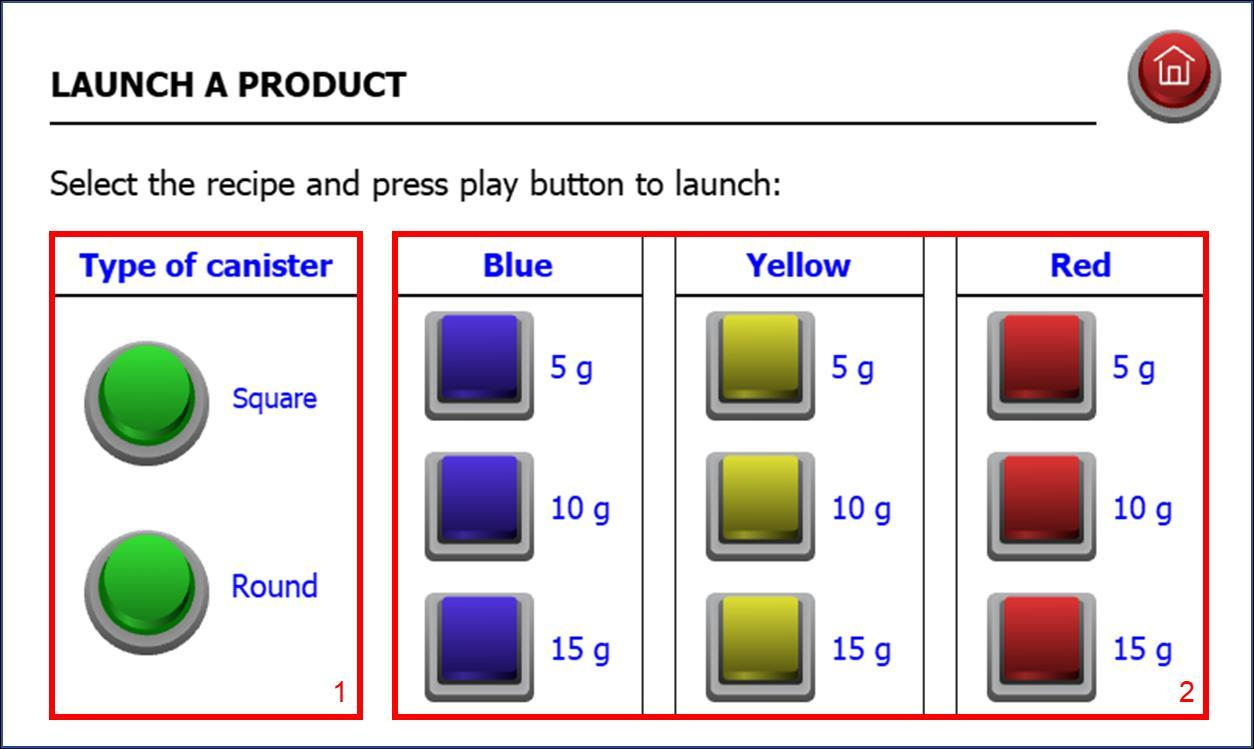

- Page 26 | Tag: SIF402_unknown


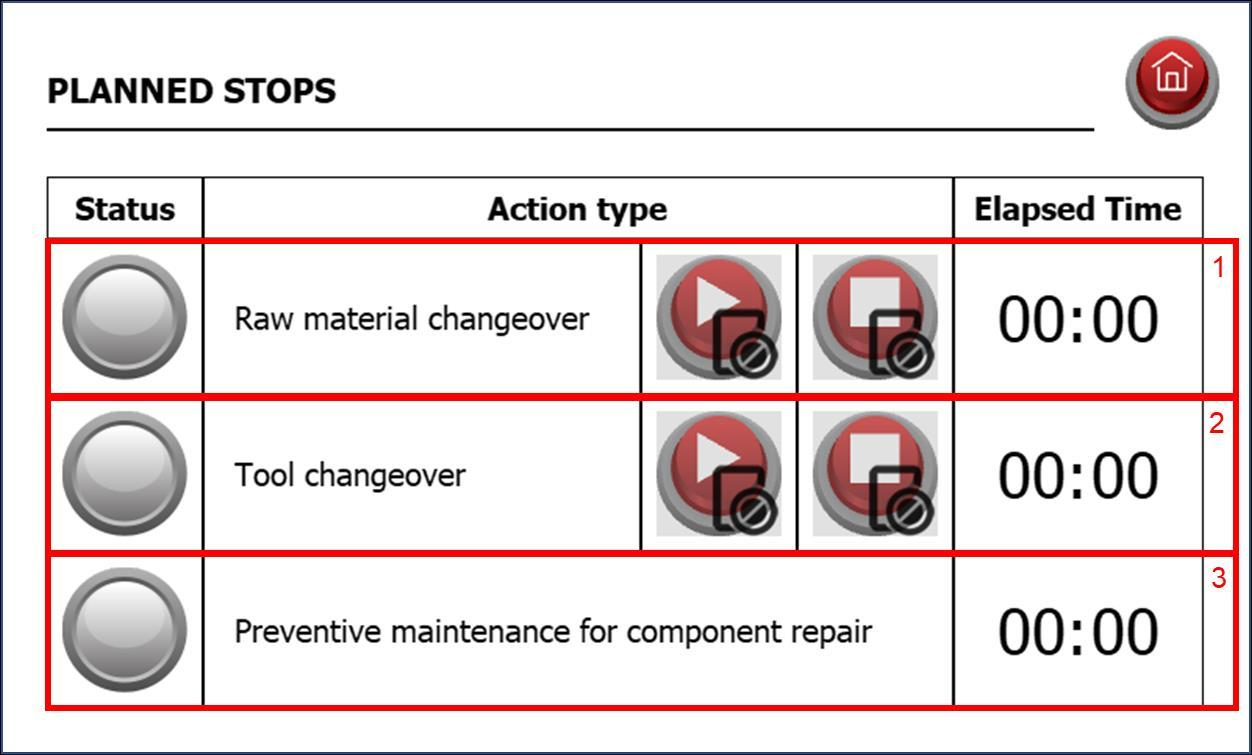

- Page 16 | Tag: SIF402_unknown


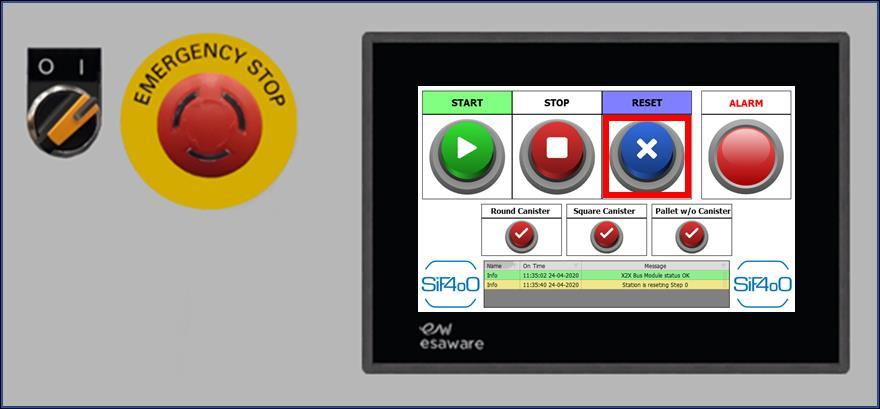

In [49]:
# --- 7) Example usage ---
if __name__ == "__main__":
    ask(f"How to switch on and start up the station {MACHINE_NAME} ?")